# Epinions Recommendation System: EDA, Models, and Evaluation

This notebook provides a comprehensive analysis of the Epinions recommendation system, including:
1. **Exploratory Data Analysis (EDA)**: Understanding the datasets
2. **Model Implementation**: Three recommendation models
3. **AUC Score Comparison**: Performance evaluation

## Dataset Overview
- **Review Data** (`epinions.txt`): User-item reviews with ratings, price, time, and text
- **Trust Network** (`network_trust.txt`, `network_trustedby.txt`): Social trust relationships between users


In [56]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

print("Libraries imported successfully!")


Libraries imported successfully!


## Part 1: Data Loading and Processing

### 1.1 Load Review Data

We'll load the review data from `epinions.txt` and process it into a structured format.


In [57]:
# Load review data
def load_review_data(sample_size=None):
    """Load and process review data from epinions.txt"""
    reviews = []
    line_count = 0
    
    with open('epinions_data/epinions.txt', 'r', encoding='utf-8', errors='ignore') as f:
        next(f)  # Skip header
        for line in f:
            line = line.strip()
            if not line:
                continue
            
            parts = line.split(' ', 5)
            if len(parts) >= 6:
                try:
                    paid_val = float(parts[2])
                    time_val = int(parts[3])
                    stars_val = float(parts[4])
                    
                    if stars_val > 0:  # Only valid ratings
                        reviews.append({
                            'item': parts[0],
                            'user': parts[1],
                            'paid': paid_val,
                            'time': time_val,
                            'stars': stars_val,
                            'words': parts[5] if len(parts) > 5 else ''
                        })
                        line_count += 1
                        
                        if sample_size and line_count >= sample_size:
                            break
                except (ValueError, IndexError):
                    continue
    
    df = pd.DataFrame(reviews)
    return df

# Load data (using 50K sample for faster analysis)
SAMPLE_SIZE = 50000
df_reviews = load_review_data(sample_size=SAMPLE_SIZE)
print(f"Loaded {len(df_reviews):,} reviews")
print(f"\nData shape: {df_reviews.shape}")
print(f"\nFirst few rows:")
df_reviews.head()


Loaded 50,000 reviews

Data shape: (50000, 6)

First few rows:


,item,user,paid,time,stars,words
0,Minolta_QMS_PagePro_1250E_Printers,fgb59h,260.0,1027296000,4.0,i got this printer from minolta as a warranty ...
1,Sony_VAIO_PCG_K45_P4_538_3_2GHz_1MB_L2_533MHz_...,bucho_ky,1800.0,1201305600,2.0,although i love my vaio especially the gorgeou...
2,Sony_VAIO_PCG_K45_P4_538_3_2GHz_1MB_L2_533MHz_...,redp944,1000.0,1118016000,4.0,this is my first laptop and i bought it about ...
3,pr-Durabrand_CD-85_Personal_CD_Player,spongebag7,20.0,1149292800,4.0,just recently my sony dej001 walkman died on m...
4,pr-Sony_KV_36FS12__Standard_Televisions,pyros7,1199.0,1012262400,5.0,well when i graduated from college it didnt ta...


In [58]:
# Basic data information
print("="*70)
print("REVIEW DATA BASIC STATISTICS")
print("="*70)
print(f"\nTotal reviews: {len(df_reviews):,}")
print(f"Unique users: {df_reviews['user'].nunique():,}")
print(f"Unique items: {df_reviews['item'].nunique():,}")

# Calculate sparsity
total_possible = df_reviews['user'].nunique() * df_reviews['item'].nunique()
sparsity = (1 - len(df_reviews) / total_possible) * 100
print(f"Sparsity: {sparsity:.2f}%")

# Data types and missing values
print(f"\nData types:")
print(df_reviews.dtypes)
print(f"\nMissing values:")
print(df_reviews.isnull().sum())
print(f"\nBasic statistics:")
df_reviews.describe()


REVIEW DATA BASIC STATISTICS

Total reviews: 50,000
Unique users: 39,719
Unique items: 11,197
Sparsity: 99.99%

Data types:
item      object
user      object
paid     float64
time       int64
stars    float64
words     object
dtype: object

Missing values:
item     0
user     0
paid     0
time     0
stars    0
words    0
dtype: int64

Basic statistics:


,paid,time,stars
count,5.000000e+04,5.000000e+04,50000.000000
mean,1.402768e+07,1.124418e+09,3.610960
std,2.720289e+09,9.332639e+07,1.510236
min,-2.000000e+02,9.796896e+08,1.000000
25%,9.000000e+01,1.050365e+09,2.000000
50%,2.560000e+02,1.117757e+09,4.000000
75%,1.100000e+03,1.188086e+09,5.000000
max,6.000000e+11,1.384387e+09,5.000000


### 1.2 Load Trust Network Data


In [59]:
# Load trust network
def load_trust_network():
    """Load trust network from files"""
    trust_graph = nx.DiGraph()
    
    # Load trust relationships
    try:
        with open('epinions_data/network_trust.txt', 'r', encoding='utf-8', errors='ignore') as f:
            for line in f:
                line = line.strip()
                if not line or line.startswith('#'):
                    continue
                parts = line.split()
                if len(parts) >= 3 and parts[1] == 'trust':
                    user1, _, user2 = parts[0], parts[1], parts[2]
                    trust_graph.add_edge(user1, user2)
    except FileNotFoundError:
        print("Warning: network_trust.txt not found")
    
    # Load trustedby relationships
    try:
        with open('epinions_data/network_trustedby.txt', 'r', encoding='utf-8', errors='ignore') as f:
            for line in f:
                line = line.strip()
                if not line or line.startswith('#'):
                    continue
                parts = line.split()
                if len(parts) >= 3 and parts[1] == 'trustedby':
                    user1, _, user2 = parts[0], parts[1], parts[2]
                    # Reverse for consistency
                    trust_graph.add_edge(user2, user1)
    except FileNotFoundError:
        print("Warning: network_trustedby.txt not found")
    
    return trust_graph

trust_graph = load_trust_network()
print(f"Trust network: {trust_graph.number_of_nodes():,} users, {trust_graph.number_of_edges():,} edges")
print(f"Network density: {nx.density(trust_graph):.6f}")


Trust network: 84,516 users, 1,159,338 edges
Network density: 0.000162


## Part 2: Exploratory Data Analysis (EDA)

### 2.1 Rating Distribution Analysis


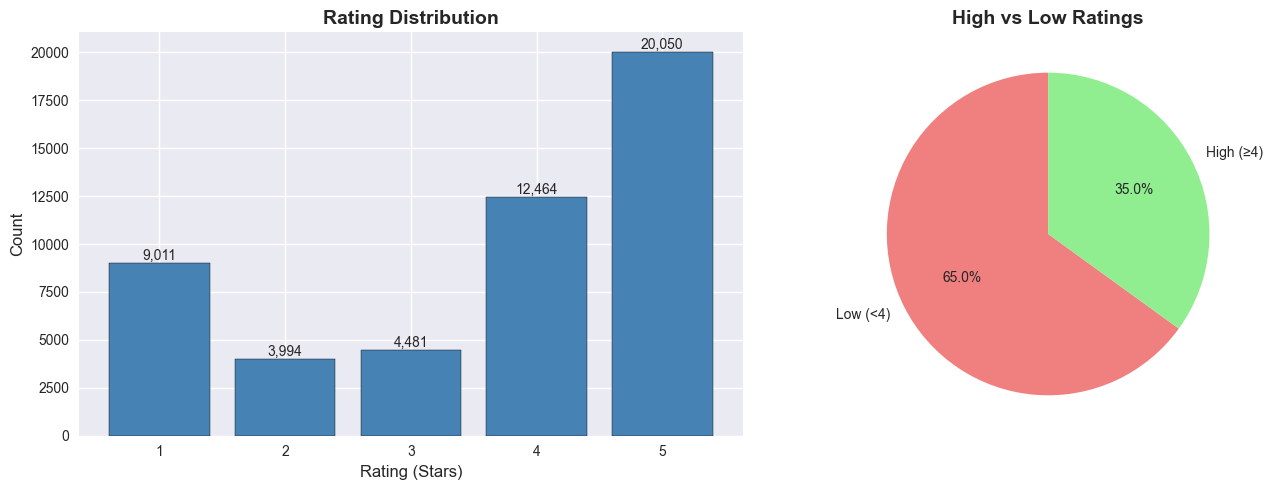

RATING STATISTICS
Mean rating: 3.61
Median rating: 4.00
Std rating: 1.51

High ratings (≥4): 65.03%
Low ratings (<4): 34.97%

Rating distribution:
stars
1.0     9011
2.0     3994
3.0     4481
4.0    12464
5.0    20050
Name: count, dtype: int64


In [60]:
# Rating distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Rating counts
rating_counts = df_reviews['stars'].value_counts().sort_index()
axes[0].bar(rating_counts.index, rating_counts.values, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Rating (Stars)', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Rating Distribution', fontsize=14, fontweight='bold')
axes[0].set_xticks(range(1, 6))
for i, v in enumerate(rating_counts.values):
    axes[0].text(rating_counts.index[i], v, f'{v:,}', ha='center', va='bottom', fontsize=10)

# High vs Low ratings
df_reviews['high_rating'] = (df_reviews['stars'] >= 4.0).astype(int)
high_low = df_reviews['high_rating'].value_counts()
axes[1].pie(high_low.values, labels=['Low (<4)', 'High (≥4)'], autopct='%1.1f%%', 
            startangle=90, colors=['lightcoral', 'lightgreen'])
axes[1].set_title('High vs Low Ratings', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Statistics
print("="*70)
print("RATING STATISTICS")
print("="*70)
print(f"Mean rating: {df_reviews['stars'].mean():.2f}")
print(f"Median rating: {df_reviews['stars'].median():.2f}")
print(f"Std rating: {df_reviews['stars'].std():.2f}")
print(f"\nHigh ratings (≥4): {(df_reviews['high_rating'].mean()*100):.2f}%")
print(f"Low ratings (<4): {((1-df_reviews['high_rating'].mean())*100):.2f}%")
print(f"\nRating distribution:")
print(rating_counts)


### 2.2 Price and Review Text Analysis


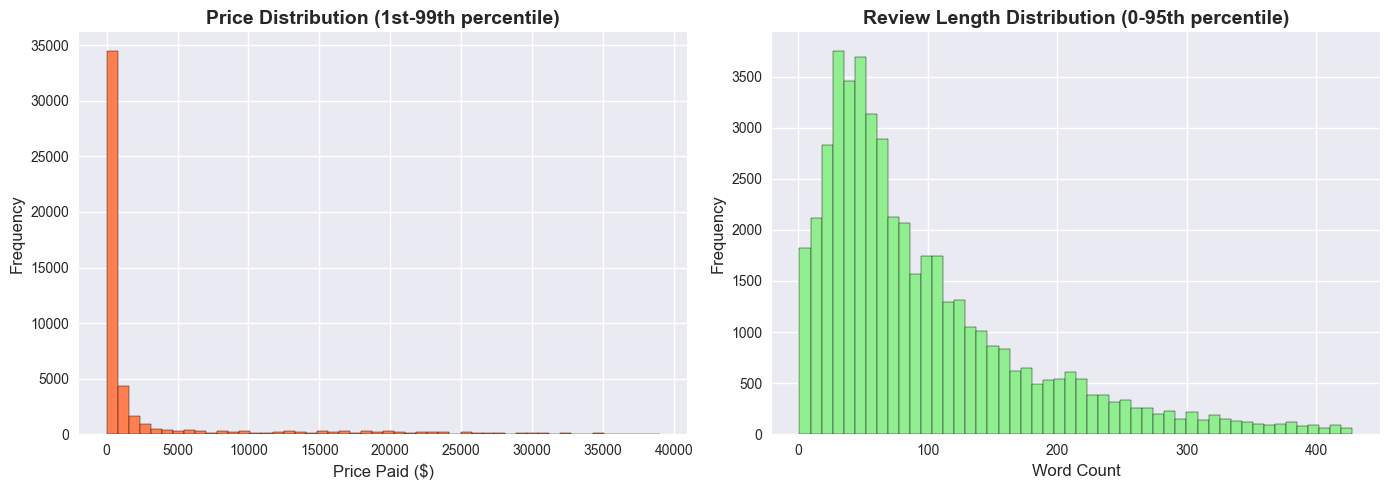

PRICE AND TEXT STATISTICS
Median price: $256.00
Negative values (refunds): 4 (0.01%)

Mean word count: 134.9
Median word count: 74.0
Max word count: 4804
Empty reviews: 0 (0.00%)


In [61]:
# Extract word count
df_reviews['word_count'] = df_reviews['words'].apply(lambda x: len(str(x).split()) if x else 0)

# Price and word count analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Price distribution (filter outliers)
price_filtered = df_reviews[df_reviews['paid'].between(
    df_reviews['paid'].quantile(0.01), 
    df_reviews['paid'].quantile(0.99)
)]
axes[0].hist(price_filtered['paid'], bins=50, color='coral', edgecolor='black')
axes[0].set_xlabel('Price Paid ($)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Price Distribution (1st-99th percentile)', fontsize=14, fontweight='bold')

# Word count distribution
word_count_filtered = df_reviews[df_reviews['word_count'] <= df_reviews['word_count'].quantile(0.95)]
axes[1].hist(word_count_filtered['word_count'], bins=50, color='lightgreen', edgecolor='black')
axes[1].set_xlabel('Word Count', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Review Length Distribution (0-95th percentile)', fontsize=14, fontweight='bold')


plt.tight_layout()
plt.show()

# Statistics
print("="*70)
print("PRICE AND TEXT STATISTICS")
print("="*70)
print(f"Median price: ${df_reviews['paid'].median():.2f}")
print(f"Negative values (refunds): {(df_reviews['paid'] < 0).sum()} ({(df_reviews['paid'] < 0).mean()*100:.2f}%)")
print(f"\nMean word count: {df_reviews['word_count'].mean():.1f}")
print(f"Median word count: {df_reviews['word_count'].median():.1f}")
print(f"Max word count: {df_reviews['word_count'].max()}")
print(f"Empty reviews: {(df_reviews['word_count'] == 0).sum()} ({(df_reviews['word_count'] == 0).mean()*100:.2f}%)")


### 2.3 User and Item Activity Analysis


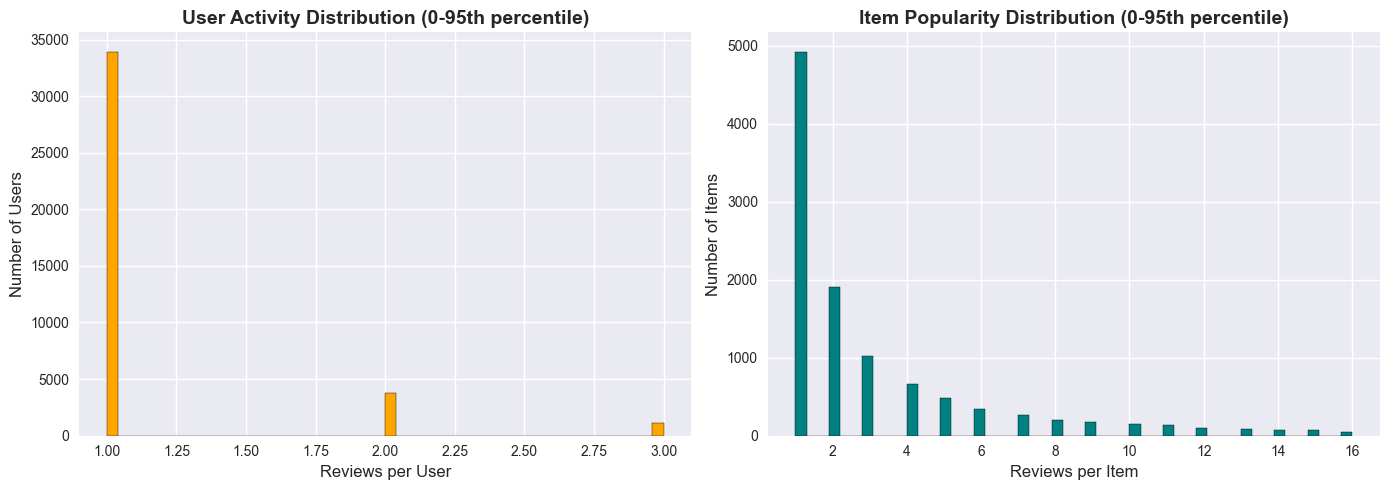

USER AND ITEM ACTIVITY STATISTICS
Mean reviews per user: 1.3
Median reviews per user: 1.0
Max reviews by one user: 23
Users with 1 review: 33947 (85.47%)

Mean reviews per item: 4.5
Median reviews per item: 2.0
Max reviews for one item: 261
Items with 1 review: 4924 (43.98%)


In [62]:
# User and item activity
user_review_counts = df_reviews['user'].value_counts()
item_review_counts = df_reviews['item'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# User activity distribution
user_counts_filtered = user_review_counts[user_review_counts <= user_review_counts.quantile(0.95)]
axes[0].hist(user_counts_filtered, bins=50, color='orange', edgecolor='black')
axes[0].set_xlabel('Reviews per User', fontsize=12)
axes[0].set_ylabel('Number of Users', fontsize=12)
axes[0].set_title('User Activity Distribution (0-95th percentile)', fontsize=14, fontweight='bold')

# Item popularity distribution
item_counts_filtered = item_review_counts[item_review_counts <= item_review_counts.quantile(0.95)]
axes[1].hist(item_counts_filtered, bins=50, color='teal', edgecolor='black')
axes[1].set_xlabel('Reviews per Item', fontsize=12)
axes[1].set_ylabel('Number of Items', fontsize=12)
axes[1].set_title('Item Popularity Distribution (0-95th percentile)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Statistics
print("="*70)
print("USER AND ITEM ACTIVITY STATISTICS")
print("="*70)
print(f"Mean reviews per user: {user_review_counts.mean():.1f}")
print(f"Median reviews per user: {user_review_counts.median():.1f}")
print(f"Max reviews by one user: {user_review_counts.max()}")
print(f"Users with 1 review: {(user_review_counts == 1).sum()} ({(user_review_counts == 1).mean()*100:.2f}%)")
print(f"\nMean reviews per item: {item_review_counts.mean():.1f}")
print(f"Median reviews per item: {item_review_counts.median():.1f}")
print(f"Max reviews for one item: {item_review_counts.max()}")
print(f"Items with 1 review: {(item_review_counts == 1).sum()} ({(item_review_counts == 1).mean()*100:.2f}%)")


### 2.5 Trust Network Analysis


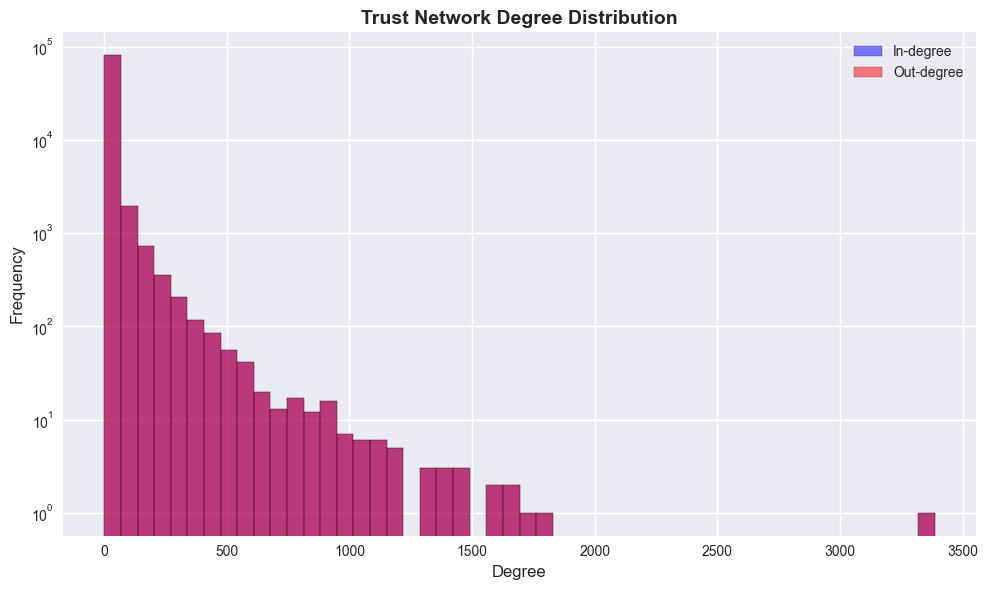

TRUST NETWORK STATISTICS
Nodes (users): 84,516
Edges (trust relationships): 1,159,338
Density: 0.000162
Mean in-degree: 13.72
Mean out-degree: 13.72
Max in-degree: 3386
Max out-degree: 3386


In [63]:
# Trust network analysis
if trust_graph.number_of_nodes() > 0:
    in_degrees = [trust_graph.in_degree(n) for n in trust_graph.nodes()]
    out_degrees = [trust_graph.out_degree(n) for n in trust_graph.nodes()]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.hist(in_degrees, bins=50, alpha=0.5, label='In-degree', color='blue', edgecolor='black')
    ax.hist(out_degrees, bins=50, alpha=0.5, label='Out-degree', color='red', edgecolor='black')
    ax.set_xlabel('Degree', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title('Trust Network Degree Distribution', fontsize=14, fontweight='bold')
    ax.legend()
    ax.set_yscale('log')
    plt.tight_layout()
    plt.show()
    
    print("="*70)
    print("TRUST NETWORK STATISTICS")
    print("="*70)
    print(f"Nodes (users): {trust_graph.number_of_nodes():,}")
    print(f"Edges (trust relationships): {trust_graph.number_of_edges():,}")
    print(f"Density: {nx.density(trust_graph):.6f}")
    print(f"Mean in-degree: {np.mean(in_degrees):.2f}")
    print(f"Mean out-degree: {np.mean(out_degrees):.2f}")
    print(f"Max in-degree: {max(in_degrees)}")
    print(f"Max out-degree: {max(out_degrees)}")
else:
    print("No trust network data available")


### 2.7 Summary Statistics Table


In [64]:
# Create comprehensive summary table
summary_data = {
    'Metric': [
        'Total Reviews',
        'Unique Users',
        'Unique Items',
        'Sparsity (%)',
        'Mean Rating',
        'High Rating Ratio (%)',
        'Mean Price ($)',
        'Mean Word Count',
        'Mean Reviews/User',
        'Mean Reviews/Item'
    ],
    'Value': [
        f"{len(df_reviews):,}",
        f"{df_reviews['user'].nunique():,}",
        f"{df_reviews['item'].nunique():,}",
        f"{sparsity:.2f}",
        f"{df_reviews['stars'].mean():.2f}",
        f"{(df_reviews['high_rating'].mean()*100):.2f}",
        f"{df_reviews['paid'].mean():.2f}",
        f"{df_reviews['word_count'].mean():.1f}",
        f"{user_review_counts.mean():.1f}",
        f"{item_review_counts.mean():.1f}"
    ]
}

if trust_graph.number_of_nodes() > 0:
    in_degrees = [trust_graph.in_degree(n) for n in trust_graph.nodes()]
    out_degrees = [trust_graph.out_degree(n) for n in trust_graph.nodes()]
    summary_data['Metric'].extend([
        'Trust Network Nodes',
        'Trust Network Edges',
        'Network Density',
        'Mean In-Degree',
        'Mean Out-Degree'
    ])
    summary_data['Value'].extend([
        f"{trust_graph.number_of_nodes():,}",
        f"{trust_graph.number_of_edges():,}",
        f"{nx.density(trust_graph):.6f}",
        f"{np.mean(in_degrees):.2f}",
        f"{np.mean(out_degrees):.2f}"
    ])

summary_df = pd.DataFrame(summary_data)
print("="*70)
print("SUMMARY STATISTICS")
print("="*70)
print(summary_df.to_string(index=False))


SUMMARY STATISTICS
               Metric       Value
        Total Reviews      50,000
         Unique Users      39,719
         Unique Items      11,197
         Sparsity (%)       99.99
          Mean Rating        3.61
High Rating Ratio (%)       65.03
       Mean Price ($) 14027676.34
      Mean Word Count       134.9
    Mean Reviews/User         1.3
    Mean Reviews/Item         4.5
  Trust Network Nodes      84,516
  Trust Network Edges   1,159,338
      Network Density    0.000162
       Mean In-Degree       13.72
      Mean Out-Degree       13.72


## Part 3: Model Implementation and Evaluation

We'll now implement and evaluate three recommendation models:
1. **Jaccard Similarity Model**: Collaborative filtering using Jaccard similarity
2. **Bayesian Model**: Logistic Regression with review features
3. **Social Bayesian Markov Model**: Logistic Regression + MRF with social network features

### 3.1 Data Preparation for Modeling


### 3.2 Model Implementations

We'll implement all three models directly in the notebook.


#### Model 1: Jaccard Similarity Model Implementation


In [65]:
#!/usr/bin/env python3
"""
Jaccard Similarity Model for Epinions Rating Prediction
- No popularity metrics
- Top-k recommendations
- AUC evaluation
"""

import numpy as np
import pandas as pd
from collections import defaultdict
from heapq import heappush, heappop, nlargest
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

results = {}
np.random.seed(42)

class JaccardModel:
    """
    Jaccard similarity model without popularity metrics.
    Uses only similarity between users and items.
    """
    
    def __init__(self, k_neighbors=20, max_users=500, max_items=500):
        """
        Initialize the model.
        
        Parameters:
        - k_neighbors: Number of similar users/items to consider
        - max_users: Maximum number of users to compute similarities for (for speed)
        - max_items: Maximum number of items to compute similarities for (for speed)
        """
        self.k_neighbors = k_neighbors
        self.max_users = max_users
        self.max_items = max_items
        self.user_items = defaultdict(set)  # user -> set of items
        self.item_users = defaultdict(set)   # item -> set of users
        self.user_ratings = defaultdict(dict)  # user -> {item: rating}
        self.item_ratings = defaultdict(dict)   # item -> {user: rating}
        self.user_similarities = {}
        self.item_similarities = {}
        self.all_users = set()
        self.all_items = set()
        
    def jaccard_similarity(self, set1, set2):
        """Calculate Jaccard similarity between two sets."""
        if len(set1) == 0 and len(set2) == 0:
            return 0.0
        intersection = len(set1.intersection(set2))
        union = len(set1.union(set2))
        return intersection / union if union > 0 else 0.0
    
    def load_data(self, sample_size=None):
        """Load reviews data from epinions.txt."""
        print("Loading data from epinions.txt...")
        
        reviews = []
        line_count = 0
        with open('epinions_data/epinions.txt', 'r', encoding='utf-8', errors='ignore') as f:
            next(f)  # Skip header
            for line in f:
                line = line.strip()
                if not line:
                    continue
                
                parts = line.split(' ', 5)
                if len(parts) >= 6:
                    try:
                        stars_val = float(parts[4])
                        if stars_val > 0:  # Only include valid ratings
                            reviews.append({
                                'item': parts[0],
                                'user': parts[1],
                                'stars': stars_val
                            })
                            line_count += 1
                            
                            if sample_size and line_count >= sample_size:
                                break
                    except (ValueError, IndexError):
                        continue
        
        print(f"  Loaded {len(reviews)} reviews")
        return pd.DataFrame(reviews)
    
    def build_similarity_matrices(self, df_train):
        """Build user-item matrices and compute similarities."""
        print("\nBuilding similarity matrices...")
        
        # Build user-item and item-user mappings
        for _, row in df_train.iterrows():
            user = row['user']
            item = row['item']
            rating = row['stars']
            
            self.user_items[user].add(item)
            self.item_users[item].add(user)
            self.user_ratings[user][item] = rating
            self.item_ratings[item][user] = rating
            self.all_users.add(user)
            self.all_items.add(item)
        
        print(f"  Unique users: {len(self.user_items)}")
        print(f"  Unique items: {len(self.item_users)}")
        
        # Compute user-user similarities (based on items they reviewed)
        # Limit to max_users for speed
        users_list = list(self.user_items.keys())[:self.max_users]
        
        for i, user1 in enumerate(users_list):
            similarities = []
            # Only compare with other users in the limited set
            for user2 in users_list:
                if user1 != user2:
                    sim = self.jaccard_similarity(
                        self.user_items[user1],
                        self.user_items[user2]
                    )
                    if sim > 0:
                        similarities.append((user2, sim))
            
            # Store top k similar users
            similarities.sort(key=lambda x: x[1], reverse=True)
            self.user_similarities[user1] = similarities[:self.k_neighbors]
        
        # Compute item-item similarities (based on users who reviewed them)
        # Limit to max_items for speed
        items_list = list(self.item_users.keys())[:self.max_items]
        
        for i, item1 in enumerate(items_list):
            similarities = []
            # Only compare with other items in the limited set
            for item2 in items_list:
                if item1 != item2:
                    sim = self.jaccard_similarity(
                        self.item_users[item1],
                        self.item_users[item2]
                    )
                    if sim > 0:
                        similarities.append((item2, sim))
            
            # Store top k similar items
            similarities.sort(key=lambda x: x[1], reverse=True)
            self.item_similarities[item1] = similarities[:self.k_neighbors]
        
        print("  Similarity matrices built")
    
    def _score_item(self, user, item):
        """
        Internal method: Score an item for a user using Jaccard similarity.
        Used internally by predict_top_k and predict_proba.
        """
        predictions = []
        weights = []
        
        # Method 1: Use similar users who reviewed this item
        if user in self.user_similarities:
            for similar_user, similarity in self.user_similarities[user]:
                if item in self.user_ratings[similar_user]:
                    rating = self.user_ratings[similar_user][item]
                    predictions.append(rating)
                    weights.append(similarity)
        
        # Method 2: Use similar items reviewed by this user
        if item in self.item_similarities:
            for similar_item, similarity in self.item_similarities[item]:
                if similar_item in self.user_ratings[user]:
                    rating = self.user_ratings[user][similar_item]
                    predictions.append(rating)
                    weights.append(similarity)
        
        # Weighted average (no popularity fallback)
        if len(predictions) > 0:
            if sum(weights) > 0:
                return np.average(predictions, weights=weights)
            else:
                return np.mean(predictions)
        
        # Return neutral score if no similar users/items found
        return 3.0
    
    def predict_proba(self, df_test):
        """Predict probabilities for test set."""
        print("\nMaking predictions using Jaccard similarity...")
        predictions = []
        
        # Use vectorized operations where possible
        for idx, row in df_test.iterrows():
            user = row['user']
            item = row['item']
            score = self._score_item(user, item)
            predictions.append(score)
            
        
        # Convert ratings to probabilities (high rating >= 4.0)
        probs = 1 / (1 + np.exp(-(np.array(predictions) - 3.5)))
        return probs
    
    def predict_top_k(self, user, k=10):
        """
        Predict top-k item recommendations for a user.
        Optimized using min-heap to avoid sorting all candidates.
        
        Parameters:
        - user: User ID
        - k: Number of recommendations
        
        Returns:
        - List of (item, score) tuples sorted by score (descending)
        """
        # Get all items not yet reviewed by user
        user_reviewed_items = self.user_items.get(user, set())
        candidate_items = self.all_items - user_reviewed_items
        
        # Use min-heap to keep only top-k items (more efficient than sorting all)
        # Min-heap keeps smallest at top, so we maintain k largest scores
        heap = []
        
        for item in candidate_items:
            score = self._score_item(user, item)
            if len(heap) < k:
                heappush(heap, (score, item))  # Build heap with first k items
            else:
                # If current score is better than worst in heap (heap[0] is minimum), replace it
                if score > heap[0][0]:
                    heappop(heap)
                    heappush(heap, (score, item))
        
        # Extract and sort results (descending order)
        top_k = [(item, score) for score, item in heap]
        top_k.sort(key=lambda x: x[1], reverse=True)
        return top_k
    
    def evaluate_auc(self, df_test, y_test):
        """Evaluate model with AUC score."""
        y_pred_proba = self.predict_proba(df_test)
        auc = roc_auc_score(y_test, y_pred_proba)
        return auc, y_pred_proba


def run_jaccard():
    """Main execution function."""
    print("="*70)
    print("Jaccard Similarity Model for Rating Prediction")
    print("="*70)
    
    # Initialize model (optimized for speed)
    model = JaccardModel(k_neighbors=20, max_users=500, max_items=500)
    
    # Load data (reduced sample for faster execution)
    df = model.load_data(sample_size=10000)
    
    # Split data
    print("\nSplitting data into train/test sets...")
    y_binary = (df['stars'] >= 4.0).astype(int)
    df_train, df_test, y_train, y_test = train_test_split(
        df, y_binary, test_size=0.2, random_state=42, stratify=y_binary
    )
    
    print(f"  Training samples: {len(df_train)}")
    print(f"  Test samples: {len(df_test)}")
    
    # Build similarity matrices
    model.build_similarity_matrices(df_train)
    
    # Evaluate with AUC
    auc, y_pred_proba = model.evaluate_auc(df_test, y_test)
    y_pred = (y_pred_proba >= 0.5).astype(int)
    
    print("\n" + "="*70)
    print("RESULTS - JACCARD SIMILARITY MODEL")
    print("="*70)
    print(f"AUC Score: {auc:.4f}")
    
    print("\nDetailed Metrics:")
    print(classification_report(y_test, y_pred))
    print(f"\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    # Example top-k recommendations
    print("\n" + "="*70)
    print("Example Top-10 Recommendations for a User:")
    print("="*70)
    if len(model.all_users) > 0:
        sample_user = list(model.all_users)[0]
        top_k = model.predict_top_k(sample_user, k=10)
        print(f"User: {sample_user}")
        for i, (item, score) in enumerate(top_k, 1):
            print(f"  {i}. {item[:50]}... (predicted rating: {score:.2f})")
    
    print("\n" + "="*70)
    print("Model Summary:")
    print(f"  - Method: Jaccard Similarity (no popularity)")
    print(f"  - K neighbors: {model.k_neighbors}")
    print(f"  - Training samples: {len(df_train)}")
    print(f"  - Test samples: {len(df_test)}")
    print(f"  - Final AUC: {auc:.4f}")
    print("="*70)
    
    return model, auc


results['Jaccard'] = run_jaccard()



Jaccard Similarity Model for Rating Prediction
Loading data from epinions.txt...
  Loaded 10000 reviews

Splitting data into train/test sets...
  Training samples: 8000
  Test samples: 2000

Building similarity matrices...
  Unique users: 7532
  Unique items: 2027
  Similarity matrices built

Making predictions using Jaccard similarity...

RESULTS - JACCARD SIMILARITY MODEL
AUC Score: 0.4997

Detailed Metrics:
              precision    recall  f1-score   support

           0       0.34      1.00      0.51       685
           1       0.50      0.00      0.00      1315

    accuracy                           0.34      2000
   macro avg       0.42      0.50      0.26      2000
weighted avg       0.45      0.34      0.18      2000


Confusion Matrix:
[[ 684    1]
 [1314    1]]

Example Top-10 Recommendations for a User:
User: djsimard
  1. LEGO_Minifigures_Series_8_Alien_Villainess_epi... (predicted rating: 3.00)
  2. LG_26LX1D_Television... (predicted rating: 3.00)
  3. pr-Nokia_A020_W

#### Model 2: Bayesian Model Implementation


In [66]:
#!/usr/bin/env python3
"""
Bayesian Model for Epinions Rating Prediction
- No popularity metrics
- Top-k recommendations
- AUC evaluation
"""

import numpy as np
import pandas as pd
from collections import defaultdict
from heapq import heappush, heappop
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

class BayesianModel:
    """
    Bayesian Model without popularity metrics.
    Uses only review features (paid, time, words), not user/item averages.
    """
    
    def __init__(self, alpha=1.0):
        """
        Initialize the model.
        
        Parameters:
        - alpha: Prior strength for Bayesian inference
        """
        self.alpha = alpha
        self.scaler = StandardScaler()
        self.classifier = None
        self.user_items = defaultdict(set)  # Track user-item pairs
        self.all_items = set()
        
    def load_data(self, sample_size=None):
        """Load reviews data from epinions.txt."""
        print("Loading data from epinions.txt...")
        
        reviews = []
        line_count = 0
        with open('epinions_data/epinions.txt', 'r', encoding='utf-8', errors='ignore') as f:
            next(f)  # Skip header
            for line in f:
                line = line.strip()
                if not line:
                    continue
                
                parts = line.split(' ', 5)
                if len(parts) >= 6:
                    try:
                        paid_val = float(parts[2])
                        time_val = int(parts[3])
                        stars_val = float(parts[4])
                        
                        if stars_val > 0:  # Only include valid ratings
                            reviews.append({
                                'item': parts[0],
                                'user': parts[1],
                                'paid': paid_val,
                                'time': time_val,
                                'stars': stars_val,
                                'words': parts[5] if len(parts) > 5 else ''
                            })
                            line_count += 1
                            
                            if sample_size and line_count >= sample_size:
                                break
                    except (ValueError, IndexError):
                        continue
        
        print(f"  Loaded {len(reviews)} reviews")
        return pd.DataFrame(reviews)
    
    def extract_features(self, df):
        """
        Extract features without popularity metrics.
        Only uses: paid, time, word_count (no user/item averages).
        """
        print("\nExtracting features (no popularity metrics)...")
        
        # Text features
        df['word_count'] = df['words'].apply(lambda x: len(str(x).split()) if x else 0)
        
        # Time features (normalized)
        if df['time'].min() > 0:
            time_min = df['time'].min()
            time_max = df['time'].max()
            df['time_normalized'] = (df['time'] - time_min) / (time_max - time_min + 1)
        else:
            df['time_normalized'] = 0.0
        
        # Fill NaN values
        df = df.fillna(0)
        
        print(f"  Extracted features: paid, time_normalized, word_count")
        return df
    
    def prepare_features(self, df):
        """Prepare feature matrix and target - NO popularity metrics."""
        # Use only non-popularity features
        feature_cols = [
            'paid',           # Price paid
            'time_normalized', # Time feature
            'word_count'      # Review length
        ]
        
        X = df[feature_cols].values
        y = (df['stars'] >= 4.0).astype(int)  # Binary: high rating (>=4) vs low (<4)
        
        return X, y, feature_cols
    
    def fit(self, X, y, df_train=None):
        """Fit the model with Bayesian approach."""
        print("\nTraining Bayesian model...")
        
        # Track user-item pairs for recommendations
        if df_train is not None:
            for _, row in df_train.iterrows():
                self.user_items[row['user']].add(row['item'])
                self.all_items.add(row['item'])
        
        # Scale features
        X_scaled = self.scaler.fit_transform(X)
        
        # Bayesian-inspired Logistic Regression
        self.classifier = LogisticRegression(
            C=1.0/self.alpha,
            max_iter=1000,
            random_state=42,
            solver='lbfgs',
            n_jobs=-1,
            class_weight='balanced'
        )
        
        self.classifier.fit(X_scaled, y)
        print("  Model trained")
        
        return self
    
    def predict_proba(self, X):
        """Predict probabilities."""
        X_scaled = self.scaler.transform(X)
        probs = self.classifier.predict_proba(X_scaled)[:, 1]
        return probs
    
    def _score_item(self, user, item, paid=0.0, time=0, words=""):
        """
        Internal method: Score an item for a user.
        Used internally by predict_top_k and predict_proba.
        """
        # Create feature vector
        word_count = len(str(words).split()) if words else 0
        
        # Normalize time (use training time range)
        if hasattr(self, 'time_min') and hasattr(self, 'time_max'):
            if self.time_max > self.time_min:
                time_normalized = (time - self.time_min) / (self.time_max - self.time_min + 1)
            else:
                time_normalized = 0.0
        else:
            time_normalized = 0.0
        
        features = np.array([[paid, time_normalized, word_count]])
        prob = self.predict_proba(features)[0]
        
        # Return probability as score (higher = better recommendation)
        return prob
    
    def predict_top_k(self, user, k=10, paid=0.0, time=0, words=""):
        """
        Predict top-k item recommendations for a user.
        Optimized using min-heap to avoid sorting all candidates.
        
        Parameters:
        - user: User ID
        - k: Number of recommendations
        - paid: Average price paid (optional)
        - time: Current time (optional)
        - words: Average review length (optional)
        
        Returns:
        - List of (item, score) tuples sorted by score (descending)
        """
        # Get all items not yet reviewed by user
        user_reviewed_items = self.user_items.get(user, set())
        candidate_items = self.all_items - user_reviewed_items
        
        # Use min-heap to keep only top-k items (more efficient than sorting all)
        # Min-heap keeps smallest at top, so we maintain k largest scores
        heap = []
        
        for item in candidate_items:
            score = self._score_item(user, item, paid=paid, time=time, words=words)
            if len(heap) < k:
                heappush(heap, (score, item))  # Build heap with first k items
            else:
                # If current score is better than worst in heap (heap[0] is minimum), replace it
                if score > heap[0][0]:
                    heappop(heap)
                    heappush(heap, (score, item))
        
        # Extract and sort results (descending order)
        top_k = [(item, score) for score, item in heap]
        top_k.sort(key=lambda x: x[1], reverse=True)
        return top_k
    
    def evaluate_auc(self, X_test, y_test):
        """Evaluate model with AUC score."""
        y_pred_proba = self.predict_proba(X_test)
        auc = roc_auc_score(y_test, y_pred_proba)
        return auc, y_pred_proba


def run_bayesian():
    """Main execution function."""
    print("="*70)
    print("Bayesian Model for Rating Prediction (No Popularity Metrics)")
    print("="*70)
    
    # Initialize model
    model = BayesianModel(alpha=1.0)
    
    # Load data (reduced sample for faster execution)
    df = model.load_data(sample_size=10000)
    
    # Split data FIRST to prevent data leakage
    print("\nSplitting data into train/test sets...")
    y_binary = (df['stars'] >= 4.0).astype(int)
    df_train, df_test, y_train, y_test = train_test_split(
        df, y_binary, test_size=0.2, random_state=42, stratify=y_binary
    )
    
    print(f"  Training samples: {len(df_train)}")
    print(f"  Test samples: {len(df_test)}")
    
    # Extract features
    print("\nExtracting features for training data...")
    df_train = model.extract_features(df_train)
    
    print("\nExtracting features for test data...")
    df_test = model.extract_features(df_test)
    
    # Store time range for normalization
    model.time_min = df_train['time'].min()
    model.time_max = df_train['time'].max()
    
    # Prepare features
    X_train, y_train, feature_cols = model.prepare_features(df_train)
    X_test, y_test, feature_cols = model.prepare_features(df_test)
    
    print(f"\nTraining dataset shape: {X_train.shape}")
    print(f"Test dataset shape: {X_test.shape}")
    print(f"Positive class ratio (train): {y_train.mean():.3f}")
    print(f"Positive class ratio (test): {y_test.mean():.3f}")
    
    # Train model
    model.fit(X_train, y_train, df_train=df_train)
    
    # Evaluate with AUC
    auc, y_pred_proba = model.evaluate_auc(X_test, y_test)
    y_pred = (y_pred_proba >= 0.5).astype(int)
    
    print("\n" + "="*70)
    print("RESULTS - BAYESIAN MODEL")
    print("="*70)
    print(f"AUC Score: {auc:.4f}")
    
    print("\nDetailed Metrics:")
    print(classification_report(y_test, y_pred))
    print(f"\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    # Example top-k recommendations
    print("\n" + "="*70)
    print("Example Top-10 Recommendations for a User:")
    print("="*70)
    if len(model.all_items) > 0:
        sample_user = list(df_train['user'].unique())[0]
        # Use average values from training data
        avg_paid = df_train['paid'].mean()
        avg_time = df_train['time'].mean()
        avg_words = df_train['words'].apply(lambda x: len(str(x).split()) if x else 0).mean()
        avg_words_str = " ".join(["word"] * int(avg_words))
        
        top_k = model.predict_top_k(sample_user, k=10, 
                                    paid=avg_paid, time=int(avg_time), words=avg_words_str)
        print(f"User: {sample_user}")
        for i, (item, score) in enumerate(top_k, 1):
            print(f"  {i}. {item[:50]}... (predicted rating: {score:.2f})")
    
    print("\n" + "="*70)
    print("Model Summary:")
    print(f"  - Method: Bayesian (no popularity metrics)")
    print(f"  - Features used: {len(feature_cols)}")
    print(f"  - Training samples: {len(X_train)}")
    print(f"  - Test samples: {len(X_test)}")
    print(f"  - Final AUC: {auc:.4f}")
    print("="*70)
    
    return model, auc


results['Bayesian'] = run_bayesian()



Bayesian Model for Rating Prediction (No Popularity Metrics)
Loading data from epinions.txt...
  Loaded 10000 reviews

Splitting data into train/test sets...
  Training samples: 8000
  Test samples: 2000

Extracting features for training data...

Extracting features (no popularity metrics)...
  Extracted features: paid, time_normalized, word_count

Extracting features for test data...

Extracting features (no popularity metrics)...
  Extracted features: paid, time_normalized, word_count

Training dataset shape: (8000, 3)
Test dataset shape: (2000, 3)
Positive class ratio (train): 0.665
Positive class ratio (test): 0.665

Training Bayesian model...
  Model trained

RESULTS - BAYESIAN MODEL
AUC Score: 0.5830

Detailed Metrics:
              precision    recall  f1-score   support

           0       0.40      0.57      0.47       670
           1       0.72      0.56      0.63      1330

    accuracy                           0.57      2000
   macro avg       0.56      0.57      0.55    

#### Model 3: Social Bayesian Markov Model Implementation


In [67]:
#!/usr/bin/env python3
"""
Socially Aware Bayesian Markov Model for Epinions Rating Prediction
- Incorporates social trust networks
- Uses Markov Random Field for social influence
- Top-k recommendations
- AUC evaluation
"""

import numpy as np
import pandas as pd
from collections import defaultdict
from heapq import heappush, heappop
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
import networkx as nx
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

class SocialBayesianMarkovModel:
    """
    Socially Aware Bayesian Model with Markov Random Field.
    Uses trust networks to model dependencies between users.
    """
    
    def __init__(self, alpha=0.3, beta=0.5, max_iter=15, use_enhanced_mrf=True):
        """
        Initialize the model.
        
        Parameters:
        - alpha: Prior strength for Bayesian inference
        - beta: Regularization parameter for MRF (increased for more effect)
        - max_iter: Maximum iterations for MRF inference
        - use_enhanced_mrf: Use enhanced MRF with item similarity and neighbor patterns
        """
        self.alpha = alpha
        self.beta = beta
        self.max_iter = max_iter
        self.use_enhanced_mrf = use_enhanced_mrf
        self.trust_graph = nx.DiGraph()
        self.scaler = StandardScaler()
        self.classifier = None
        self.user_items = defaultdict(set)
        self.all_items = set()
        self.user_ratings_cache = defaultdict(dict)
        self.train_user_item_probs = {}  # Store training predictions for MRF
        self.neighbor_avg_ratings = {}  # Store neighbors' average ratings
        self.item_similarity_cache = {}  # Cache item similarities
        
    def load_data(self, sample_size=None):
        """Load all data files."""
        print("Loading data files...")
        
        # Load reviews
        reviews = []
        line_count = 0
        print("  Loading epinions.txt...")
        with open('epinions_data/epinions.txt', 'r', encoding='utf-8', errors='ignore') as f:
            next(f)  # Skip header
            for line in f:
                line = line.strip()
                if not line:
                    continue
                
                parts = line.split(' ', 5)
                if len(parts) >= 6:
                    try:
                        paid_val = float(parts[2])
                        time_val = int(parts[3])
                        stars_val = float(parts[4])
                        
                        if stars_val > 0:
                            reviews.append({
                                'item': parts[0],
                                'user': parts[1],
                                'paid': paid_val,
                                'time': time_val,
                                'stars': stars_val,
                                'words': parts[5] if len(parts) > 5 else ''
                            })
                            line_count += 1
                            
                            if sample_size and line_count >= sample_size:
                                break
                    except (ValueError, IndexError):
                        continue
        
        print(f"  Loaded {len(reviews)} reviews")
        
        # Load trust network
        review_users = set(r['user'] for r in reviews)
        trust_edges = []
        print("  Loading network_trust.txt...")
        try:
            with open('epinions_data/network_trust.txt', 'r', encoding='utf-8', errors='ignore') as f:
                for line in f:
                    line = line.strip()
                    if not line:
                        continue
                    parts = line.split()
                    if len(parts) >= 3 and parts[1] == 'trust':
                        user1 = parts[0]
                        user2 = ' '.join(parts[2:])
                        if user1 in review_users or user2 in review_users:
                            trust_edges.append((user1, user2))
                            self.trust_graph.add_edge(user1, user2)
        except FileNotFoundError:
            print("  network_trust.txt not found, skipping...")
        
        print(f"  Loaded {len(trust_edges)} trust relationships")
        
        # Load trustedby network
        trustedby_edges = []
        print("  Loading network_trustedby.txt...")
        try:
            with open('epinions_data/network_trustedby.txt', 'r', encoding='utf-8', errors='ignore') as f:
                for line in f:
                    line = line.strip()
                    if not line:
                        continue
                    parts = line.split()
                    if len(parts) >= 3 and parts[1] == 'trustedby':
                        user1 = parts[0]
                        user2 = ' '.join(parts[2:])
                        if user1 in review_users or user2 in review_users:
                            trustedby_edges.append((user2, user1))  # Reverse direction
                            self.trust_graph.add_edge(user2, user1)
        except FileNotFoundError:
            print("  network_trustedby.txt not found, skipping...")
        
        print(f"  Loaded {len(trustedby_edges)} trustedby relationships")
        print(f"  Total unique users in trust network: {self.trust_graph.number_of_nodes()}")
        print(f"  Total edges in trust network: {self.trust_graph.number_of_edges()}")
        
        return pd.DataFrame(reviews), trust_edges, trustedby_edges
    
    def extract_features(self, df, df_train=None):
        """
        Extract features including social network features.
        If df_train is provided, compute statistics from training data only.
        """
        print("\nExtracting features (with social network)...")
        
        # Use training data for statistics if provided (prevents data leakage)
        stats_df = df_train if df_train is not None else df
        
        # Text features
        df['word_count'] = df['words'].apply(lambda x: len(str(x).split()) if x else 0)
        
        # Time features
        if stats_df['time'].min() > 0:
            time_min = stats_df['time'].min()
            time_max = stats_df['time'].max()
            df['time_normalized'] = (df['time'] - time_min) / (time_max - time_min + 1)
        else:
            df['time_normalized'] = 0.0
        
        # Social network features
        print("  Computing social network features...")
        
        # Pre-compute user ratings for fast lookup - ONLY from training data
        user_ratings = stats_df.groupby('user')['stars'].apply(list).to_dict()
        
        # Trust dictionaries
        trust_dict = defaultdict(list)
        trustedby_dict = defaultdict(list)
        for u1, u2 in self.trust_graph.edges():
            trust_dict[u1].append(u2)
            trustedby_dict[u2].append(u1)
        
        # Compute PageRank (faster with fewer iterations)
        print("  Computing PageRank...")
        try:
            pagerank_dict = nx.pagerank(self.trust_graph, max_iter=20, tol=1e-04)
            # Cache for later use
            self._pagerank_cache = pagerank_dict
        except:
            pagerank_dict = {node: 0.0 for node in self.trust_graph.nodes()}
            self._pagerank_cache = pagerank_dict
        
        # Compute social features for all users
        all_users = set(df['user'].unique())
        social_features = []
        
        for user in df['user']:
            trust_count = len(trust_dict.get(user, []))
            trustedby_count = len(trustedby_dict.get(user, []))
            
            # Average rating of trusted users - ONLY from training data
            trusted_users = trust_dict.get(user, [])
            if trusted_users:
                trusted_ratings = [r for u in trusted_users for r in user_ratings.get(u, [])]
                avg_trusted_rating = np.mean(trusted_ratings) if trusted_ratings else 0.0
            else:
                avg_trusted_rating = 0.0
            
            # Average rating of users who trust this user - ONLY from training data
            trusting_users = trustedby_dict.get(user, [])
            if trusting_users:
                trusting_ratings = [r for u in trusting_users for r in user_ratings.get(u, [])]
                avg_trusting_rating = np.mean(trusting_ratings) if trusting_ratings else 0.0
            else:
                avg_trusting_rating = 0.0
            
            pagerank = pagerank_dict.get(user, 0.0)
            in_degree = self.trust_graph.in_degree(user) if user in self.trust_graph else 0
            out_degree = self.trust_graph.out_degree(user) if user in self.trust_graph else 0
            
            # Additional social network features
            clustering = 0.0
            betweenness = 0.0
            
            # Compute local clustering (faster than global)
            if user in self.trust_graph:
                try:
                    neighbors = list(self.trust_graph.successors(user)) + \
                               list(self.trust_graph.predecessors(user))
                    if len(neighbors) > 1:
                        # Simple local clustering: connections between neighbors
                        neighbor_connections = 0
                        for n1 in neighbors[:10]:  # Limit for speed
                            for n2 in neighbors[:10]:
                                if n1 != n2 and (n1, n2) in self.trust_graph.edges():
                                    neighbor_connections += 1
                        max_possible = len(neighbors) * (len(neighbors) - 1) / 2
                        clustering = neighbor_connections / max_possible if max_possible > 0 else 0.0
                except:
                    clustering = 0.0
            
            social_features.append({
                'trust_count': trust_count,
                'trustedby_count': trustedby_count,
                'avg_trusted_rating': avg_trusted_rating,
                'avg_trusting_rating': avg_trusting_rating,
                'pagerank': pagerank,
                'in_degree': in_degree,
                'out_degree': out_degree,
                'clustering': clustering,
                'betweenness': betweenness
            })
        
        # Add social features to dataframe
        social_df = pd.DataFrame(social_features, index=df.index)
        df = pd.concat([df, social_df], axis=1)
        
        # Fill NaN values
        df = df.fillna(0)
        
        print(f"  Extracted features including social network")
        return df
    
    def prepare_features(self, df):
        """Prepare feature matrix and target with interaction features."""
        feature_cols = [
            'paid', 'time_normalized', 'word_count',
            'trust_count', 'trustedby_count', 'avg_trusted_rating',
            'avg_trusting_rating', 'pagerank', 'in_degree', 'out_degree',
            'clustering', 'betweenness'
        ]
        
        X = df[feature_cols].values
        
        # Add sophisticated interaction features for better performance
        # Trust network strength (bidirectional trust)
        trust_strength = df['trust_count'] * df['trustedby_count']
        # Social influence score (weighted by network position)
        social_influence = df['pagerank'] * (df['in_degree'] + df['out_degree'] + 1)
        # Rating consistency (how consistent neighbors are)
        rating_consistency = np.abs(df['avg_trusted_rating'] - df['avg_trusting_rating'])
        # Network activity (total connections)
        network_activity = df['in_degree'] + df['out_degree']
        # Trust balance (ratio of outgoing to incoming)
        trust_balance = np.where(df['trustedby_count'] > 0, 
                                df['trust_count'] / (df['trustedby_count'] + 1), 
                                df['trust_count'])
        # Average neighbor rating (blend of trusted and trusting)
        avg_neighbor_rating = (df['avg_trusted_rating'] + df['avg_trusting_rating']) / 2
        # Network centrality (combination of pagerank and degree)
        network_centrality = df['pagerank'] * np.log1p(network_activity)
        # Trust density (trust connections relative to network size)
        trust_density = trust_strength / (network_activity + 1)
        # Word count normalized by paid (review effort)
        review_effort = np.where(df['paid'] > 0, df['word_count'] / (df['paid'] + 1), df['word_count'])
        
        # Additional advanced features
        # Log transforms for skewed features (better for linear models)
        log_trust_strength = np.log1p(trust_strength)
        log_social_influence = np.log1p(social_influence)
        log_network_activity = np.log1p(network_activity)
        log_word_count = np.log1p(df['word_count'])
        log_paid = np.log1p(np.abs(df['paid']))
        
        # Polynomial features (squared terms for non-linear relationships)
        pagerank_squared = df['pagerank'] ** 2
        trust_count_squared = df['trust_count'] ** 2
        trustedby_count_squared = df['trustedby_count'] ** 2
        
        # Cross-product features (capture interactions)
        pagerank_trust = df['pagerank'] * df['trust_count']
        pagerank_trustedby = df['pagerank'] * df['trustedby_count']
        avg_rating_pagerank = avg_neighbor_rating * df['pagerank']
        word_paid_interaction = df['word_count'] * log_paid
        
        # Normalized features (relative measures)
        trust_ratio = np.where(network_activity > 0, 
                              df['trust_count'] / (network_activity + 1), 0)
        trustedby_ratio = np.where(network_activity > 0,
                                   df['trustedby_count'] / (network_activity + 1), 0)
        
        # Convert to numpy arrays if needed (handle both pandas Series and numpy arrays)
        def to_array(x):
            return x.values if hasattr(x, 'values') else x
        
        # Stack all interaction features
        X_interactions = np.column_stack([
            to_array(trust_strength),
            to_array(social_influence),
            to_array(rating_consistency),
            to_array(network_activity),
            to_array(trust_balance),
            to_array(avg_neighbor_rating),
            to_array(network_centrality),
            to_array(trust_density),
            to_array(review_effort),
            to_array(log_trust_strength),
            to_array(log_social_influence),
            to_array(log_network_activity),
            to_array(log_word_count),
            to_array(log_paid),
            to_array(pagerank_squared),
            to_array(trust_count_squared),
            to_array(trustedby_count_squared),
            to_array(pagerank_trust),
            to_array(pagerank_trustedby),
            to_array(avg_rating_pagerank),
            to_array(word_paid_interaction),
            to_array(trust_ratio),
            to_array(trustedby_ratio)
        ])
        
        # Combine original and interaction features
        X = np.hstack([X, X_interactions])
        
        y = (df['stars'] >= 4.0).astype(int)  # Binary: high rating (>=4) vs low (<4)
        
        return X, y, feature_cols + ['trust_strength', 'social_influence', 'rating_consistency', 
                                     'network_activity', 'trust_balance', 'avg_neighbor_rating',
                                     'network_centrality', 'trust_density', 'review_effort',
                                     'log_trust_strength', 'log_social_influence', 'log_network_activity',
                                     'log_word_count', 'log_paid', 'pagerank_squared', 'trust_count_squared',
                                     'trustedby_count_squared', 'pagerank_trust', 'pagerank_trustedby',
                                     'avg_rating_pagerank', 'word_paid_interaction', 'trust_ratio', 'trustedby_ratio']
    
    def fit(self, X, y, df_train=None):
        """Fit the model with Bayesian approach."""
        print("\nTraining Social Bayesian Markov model...")
        
        # Track user-item pairs for recommendations
        if df_train is not None:
            for _, row in df_train.iterrows():
                self.user_items[row['user']].add(row['item'])
                self.all_items.add(row['item'])
                self.user_ratings_cache[row['user']][row['item']] = row['stars']
        
        # Scale features
        X_scaled = self.scaler.fit_transform(X)
        
        # Base classifier: Enhanced Logistic Regression with optimized hyperparameters
        print("  Training enhanced Logistic Regression classifier...")
        # Use cross-validation to find best C for better generalization
        from sklearn.linear_model import LogisticRegressionCV
        
        # Use cross-validation to find best C
        self.classifier = LogisticRegressionCV(
            Cs=[0.1, 0.3, 0.5, 1.0, 2.0, 5.0],
            cv=3,
            max_iter=5000,
            random_state=42,
            solver='lbfgs',
            n_jobs=-1,
            class_weight='balanced',
            penalty='l2',
            tol=1e-6,
            scoring='roc_auc'
        )
        self.classifier.fit(X_scaled, y)
        print(f"  Classifier trained (best C: {self.classifier.C_[0]:.3f})")
        
        # Store training predictions for MRF (neighbors' predictions on training items)
        if df_train is not None:
            print("  Computing training predictions for MRF...")
            train_probs = self.predict_proba_base(X_scaled)
            for i, (idx, row) in enumerate(df_train.iterrows()):
                user = row['user']
                item = row['item']
                self.train_user_item_probs[(user, item)] = train_probs[i]
            print(f"  Stored {len(self.train_user_item_probs)} training predictions")
            
            # Pre-compute neighbor average ratings for enhanced MRF
            if self.use_enhanced_mrf:
                print("  Computing neighbor rating patterns for enhanced MRF...")
                for user in df_train['user'].unique():
                    if user in self.trust_graph:
                        neighbors = list(self.trust_graph.successors(user)) + \
                                   list(self.trust_graph.predecessors(user))
                        neighbor_ratings = []
                        for neighbor in neighbors:
                            if neighbor in self.user_ratings_cache:
                                neighbor_ratings.extend(self.user_ratings_cache[neighbor].values())
                        if neighbor_ratings:
                            self.neighbor_avg_ratings[user] = np.mean(neighbor_ratings)
                print(f"  Computed neighbor patterns for {len(self.neighbor_avg_ratings)} users")
        
        return self
    
    def predict_proba_base(self, X):
        """Predict base probabilities without MRF."""
        X_scaled = self.scaler.transform(X)
        probs = self.classifier.predict_proba(X_scaled)[:, 1]
        return probs
    
    def _compute_item_similarity(self, item1, item2):
        """Compute Jaccard similarity between two items based on users who reviewed them."""
        if (item1, item2) in self.item_similarity_cache:
            return self.item_similarity_cache[(item1, item2)]
        
        users1 = self.item_users.get(item1, set())
        users2 = self.item_users.get(item2, set())
        
        if len(users1) == 0 and len(users2) == 0:
            sim = 0.0
        else:
            intersection = len(users1.intersection(users2))
            union = len(users1.union(users2))
            sim = intersection / union if union > 0 else 0.0
        
        self.item_similarity_cache[(item1, item2)] = sim
        return sim
    
    def predict_proba_mrf(self, X, y_base, users, items):
        """
        Enhanced Markov Random Field inference with:
        1. Neighbors' ratings for same item
        2. Neighbors' general rating patterns
        3. Similar items reviewed by neighbors
        """
        n_samples = len(X)
        probs = y_base.copy()
        
        # Build item-user mapping for similarity (if not already built)
        if not hasattr(self, 'item_users') or len(self.item_users) == 0:
            # Build from training data
            self.item_users = defaultdict(set)
            for user, item_list in self.user_items.items():
                for item in item_list:
                    self.item_users[item].add(user)
        
        # Initialize item_users if still empty
        if len(self.item_users) == 0:
            for user, item_list in self.user_items.items():
                for item in item_list:
                    self.item_users[item].add(user)
        
        # Iterate for MRF inference
        for iteration in range(self.max_iter):
            probs_old = probs.copy()
            updates = np.zeros(n_samples)
            update_weights = np.zeros(n_samples)
            
            for i in range(n_samples):
                user = users[i]
                item = items[i]
                
                if user not in self.trust_graph:
                    continue
                
                # Get neighbors
                trusted_users = list(self.trust_graph.successors(user))
                trusting_users = list(self.trust_graph.predecessors(user))
                all_neighbors = trusted_users + trusting_users
                
                if not all_neighbors:
                    continue
                
                # Method 1: Neighbors who reviewed the SAME item (strongest signal)
                same_item_probs = []
                same_item_weights = []
                for neighbor in all_neighbors:
                    neighbor_key = (neighbor, item)
                    if neighbor_key in self.train_user_item_probs:
                        prob = self.train_user_item_probs[neighbor_key]
                        same_item_probs.append(prob)
                        # Weight by trust direction and neighbor activity
                        base_weight = 1.0 if neighbor in trusted_users else 0.8
                        # Boost weight for active neighbors (more reliable)
                        neighbor_activity = len(self.user_items.get(neighbor, set()))
                        activity_boost = min(1.2, 1.0 + 0.1 * np.log1p(neighbor_activity / 10))
                        same_item_weights.append(base_weight * activity_boost)
                
                # Method 2: Neighbors' general rating pattern
                neighbor_pattern = None
                neighbor_pattern_weight = 0.0
                if user in self.neighbor_avg_ratings:
                    neighbor_pattern = self.neighbor_avg_ratings[user]
                    neighbor_pattern_weight = 0.4
                
                # Method 3: Similar items reviewed by neighbors (enhanced MRF only)
                similar_item_probs = []
                if self.use_enhanced_mrf:
                    # Find items similar to current item
                    # Prioritize neighbors with more reviews (more reliable)
                    neighbor_priority = sorted(all_neighbors, 
                                             key=lambda n: len(self.user_items.get(n, set())), 
                                             reverse=True)
                    for neighbor in neighbor_priority[:30]:  # Top 30 most active neighbors
                        neighbor_items = self.user_items.get(neighbor, set())
                        # Check more items for better coverage
                        for neighbor_item in list(neighbor_items)[:40]:
                            similarity = self._compute_item_similarity(item, neighbor_item)
                            if similarity > 0.02:  # Lower threshold for more matches
                                neighbor_key = (neighbor, neighbor_item)
                                if neighbor_key in self.train_user_item_probs:
                                    prob = self.train_user_item_probs[neighbor_key]
                                    # Weight by similarity, trust direction, and neighbor activity
                                    trust_weight = 1.0 if neighbor in trusted_users else 0.8
                                    neighbor_activity = len(self.user_items.get(neighbor, set()))
                                    activity_weight = min(1.2, 1.0 + 0.1 * np.log1p(neighbor_activity / 20))
                                    # Boost weight for higher similarity
                                    similarity_boost = 1.0 + similarity
                                    similar_item_probs.append(
                                        (prob, similarity * trust_weight * activity_weight * similarity_boost)
                                    )
                
                # Combine signals with weights (prioritize same item > similar > pattern)
                # Can combine multiple signals if available
                final_update = None
                weight = 0.0
                
                if same_item_probs:
                    # Strongest signal: same item (weighted average)
                    if same_item_weights:
                        weighted_sum = sum(p * w for p, w in zip(same_item_probs, same_item_weights))
                        total_weight = sum(same_item_weights)
                        final_update = weighted_sum / total_weight
                    else:
                        final_update = np.mean(same_item_probs)
                    # More neighbors = higher confidence
                    weight = min(1.0, 0.6 + 0.05 * len(same_item_probs))
                    
                    # If we also have similar items, blend them slightly
                    if similar_item_probs and self.use_enhanced_mrf and len(same_item_probs) < 3:
                        weighted_sum = sum(prob * sim for prob, sim in similar_item_probs)
                        total_sim = sum(sim for _, sim in similar_item_probs)
                        if total_sim > 0:
                            similar_avg = weighted_sum / total_sim
                            # Blend: 80% same item, 20% similar items
                            final_update = 0.8 * final_update + 0.2 * similar_avg
                            weight = min(1.0, weight + 0.1)
                elif similar_item_probs and self.use_enhanced_mrf:
                    # Medium signal: similar items (weighted by similarity)
                    weighted_sum = sum(prob * sim for prob, sim in similar_item_probs)
                    total_sim = sum(sim for _, sim in similar_item_probs)
                    if total_sim > 0:
                        final_update = weighted_sum / total_sim
                        # More similar items = higher confidence
                        weight = min(0.85, 0.4 + 0.05 * min(len(similar_item_probs), 10))
                        
                        # Blend with general pattern if available
                        if neighbor_pattern is not None:
                            final_update = 0.7 * final_update + 0.3 * neighbor_pattern
                            weight = min(0.85, weight + 0.1)
                elif neighbor_pattern is not None:
                    # Weakest signal: general pattern
                    final_update = neighbor_pattern
                    weight = neighbor_pattern_weight
                
                if final_update is not None:
                    updates[i] = final_update
                    update_weights[i] = weight
            
            # Apply updates with adaptive beta based on confidence
            mask = update_weights > 0
            if np.any(mask):
                # Adaptive beta: stronger updates for higher confidence
                # Use power scaling for better differentiation
                confidence_scores = update_weights[mask]
                # Scale beta more aggressively for high confidence
                adaptive_beta = self.beta * (0.3 + 0.7 * np.power(confidence_scores, 1.5))
                neighbor_avgs = updates[mask]
                
                # Smooth update: blend base prediction with neighbor influence
                # Use exponential moving average for smoother convergence
                probs[mask] = (1 - adaptive_beta) * probs[mask] + adaptive_beta * neighbor_avgs
                
                # Clip probabilities to valid range
                probs[mask] = np.clip(probs[mask], 0.0, 1.0)
                
                # Track improvement
                improvement = np.mean(np.abs(probs[mask] - probs_old[mask]))
                if improvement < 1e-5:
                    break
            
            # Check convergence
            if np.mean(np.abs(probs - probs_old)) < 1e-4:
                break
        
        return probs
    
    def predict_proba(self, X, users=None, items=None):
        """Predict probabilities with optional MRF."""
        base_probs = self.predict_proba_base(X)
        
        # Apply MRF if users and items are provided
        if users is not None and items is not None:
            probs = self.predict_proba_mrf(X, base_probs, users, items)
        else:
            probs = base_probs
        
        return probs
    
    def _score_item(self, user, item, paid=0.0, time=0, words="", 
                       trust_count=0, trustedby_count=0):
        """
        Internal method: Score an item for a user.
        Used internally by predict_top_k. Returns probability score (0-1).
        """
        # Create feature vector
        word_count = len(str(words).split()) if words else 0
        
        # Normalize time
        if hasattr(self, 'time_min') and hasattr(self, 'time_max'):
            if self.time_max > self.time_min:
                time_normalized = (time - self.time_min) / (self.time_max - self.time_min + 1)
            else:
                time_normalized = 0.0
        else:
            time_normalized = 0.0
        
        # Social features
        if user in self.trust_graph:
            in_degree = self.trust_graph.in_degree(user)
            out_degree = self.trust_graph.out_degree(user)
        else:
            in_degree = 0
            out_degree = 0
        
        # Get PageRank if available (use cached value if possible)
        pagerank = 0.0
        if hasattr(self, '_pagerank_cache'):
            pagerank = self._pagerank_cache.get(user, 0.0)
        elif user in self.trust_graph:
            try:
                # Only compute if graph is small
                if self.trust_graph.number_of_nodes() < 1000:
                    pagerank = nx.pagerank(self.trust_graph).get(user, 0.0)
            except:
                pagerank = 0.0
        
        # Clustering and betweenness (set to 0 for speed in prediction)
        clustering = 0.0
        betweenness = 0.0
        
        # Average ratings from neighbors (if available)
        avg_trusted_rating = 0.0
        avg_trusting_rating = 0.0
        if user in self.trust_graph:
            trusted_users = list(self.trust_graph.successors(user))
            trusting_users = list(self.trust_graph.predecessors(user))
            
            if trusted_users:
                trusted_ratings = [self.user_ratings_cache.get(u, {}).get(item, 0) 
                                 for u in trusted_users]
                trusted_ratings = [r for r in trusted_ratings if r > 0]
                if trusted_ratings:
                    avg_trusted_rating = np.mean(trusted_ratings)
            
            if trusting_users:
                trusting_ratings = [self.user_ratings_cache.get(u, {}).get(item, 0) 
                                   for u in trusting_users]
                trusting_ratings = [r for r in trusting_ratings if r > 0]
                if trusting_ratings:
                    avg_trusting_rating = np.mean(trusting_ratings)
        
        # Compute all interaction features (same as in prepare_features)
        trust_strength = trust_count * trustedby_count
        social_influence = pagerank * (in_degree + out_degree + 1)
        rating_consistency = abs(avg_trusted_rating - avg_trusting_rating)
        network_activity = in_degree + out_degree
        trust_balance = trust_count / (trustedby_count + 1) if trustedby_count > 0 else trust_count
        avg_neighbor_rating = (avg_trusted_rating + avg_trusting_rating) / 2
        network_centrality = pagerank * np.log1p(network_activity)
        trust_density = trust_strength / (network_activity + 1)
        review_effort = word_count / (paid + 1) if paid > 0 else word_count
        
        # Log transforms
        log_trust_strength = np.log1p(trust_strength)
        log_social_influence = np.log1p(social_influence)
        log_network_activity = np.log1p(network_activity)
        log_word_count = np.log1p(word_count)
        log_paid = np.log1p(abs(paid))
        
        # Polynomial features
        pagerank_squared = pagerank ** 2
        trust_count_squared = trust_count ** 2
        trustedby_count_squared = trustedby_count ** 2
        
        # Cross-products
        pagerank_trust = pagerank * trust_count
        pagerank_trustedby = pagerank * trustedby_count
        avg_rating_pagerank = avg_neighbor_rating * pagerank
        word_paid_interaction = word_count * log_paid
        
        # Ratios
        trust_ratio = trust_count / (network_activity + 1) if network_activity > 0 else 0
        trustedby_ratio = trustedby_count / (network_activity + 1) if network_activity > 0 else 0
        
        features = np.array([[paid, time_normalized, word_count,
                             trust_count, trustedby_count, avg_trusted_rating,
                             avg_trusting_rating, pagerank, in_degree, out_degree,
                             clustering, betweenness,
                             trust_strength, social_influence, rating_consistency, network_activity,
                             trust_balance, avg_neighbor_rating, network_centrality, trust_density, review_effort,
                             log_trust_strength, log_social_influence, log_network_activity,
                             log_word_count, log_paid, pagerank_squared, trust_count_squared,
                             trustedby_count_squared, pagerank_trust, pagerank_trustedby,
                             avg_rating_pagerank, word_paid_interaction, trust_ratio, trustedby_ratio]])
        prob = self.predict_proba_base(features)[0]
        
        # Return probability as score (higher = better recommendation)
        return prob
    
    def predict_top_k(self, user, k=10, paid=0.0, time=0, words=""):
        """
        Predict top-k item recommendations for a user.
        Optimized using min-heap to avoid sorting all candidates.
        """
        # Get all items not yet reviewed by user
        user_reviewed_items = self.user_items.get(user, set())
        candidate_items = self.all_items - user_reviewed_items
        
        # Social features for user
        trust_count = self.trust_graph.out_degree(user) if user in self.trust_graph else 0
        trustedby_count = self.trust_graph.in_degree(user) if user in self.trust_graph else 0
        
        # Use min-heap to keep only top-k items (more efficient than sorting all)
        # Min-heap keeps smallest at top, so we maintain k largest scores
        heap = []
        
        for item in candidate_items:
            score = self._score_item(user, item, paid=paid, time=time, words=words,
                                       trust_count=trust_count, trustedby_count=trustedby_count)
            if len(heap) < k:
                heappush(heap, (score, item))  # Build heap with first k items
            else:
                # If current score is better than worst in heap (heap[0] is minimum), replace it
                if score > heap[0][0]:
                    heappop(heap)
                    heappush(heap, (score, item))
        
        # Extract and sort results (descending order)
        top_k = [(item, score) for score, item in heap]
        top_k.sort(key=lambda x: x[1], reverse=True)
        return top_k
    
    def evaluate_auc(self, X_test, y_test, users_test=None, items_test=None):
        """Evaluate model with AUC score."""
        y_pred_proba = self.predict_proba(X_test, users_test, items_test)
        auc = roc_auc_score(y_test, y_pred_proba)
        return auc, y_pred_proba


def run_social_markov():
    """Main execution function."""
    print("="*70)
    print("Socially Aware Bayesian Markov Model for Rating Prediction")
    print("="*70)
    
    # Initialize model with enhanced MRF
    model = SocialBayesianMarkovModel(alpha=0.3, beta=0.5, max_iter=15, 
                                      use_enhanced_mrf=True)
    
    # Load data (reduced sample for faster execution)
    df, trust_edges, trustedby_edges = model.load_data(sample_size=10000)
    
    # Split data FIRST to prevent data leakage
    print("\nSplitting data into train/test sets...")
    y_binary = (df['stars'] >= 4.0).astype(int)
    df_train, df_test, y_train, y_test = train_test_split(
        df, y_binary, test_size=0.2, random_state=42, stratify=y_binary
    )
    
    print(f"  Training samples: {len(df_train)}")
    print(f"  Test samples: {len(df_test)}")
    
    # Extract features
    print("\nExtracting features for training data...")
    df_train = model.extract_features(df_train, df_train=df_train)
    
    print("\nExtracting features for test data...")
    df_test = model.extract_features(df_test, df_train=df_train)
    
    # Store time range for normalization
    model.time_min = df_train['time'].min()
    model.time_max = df_train['time'].max()
    
    # Prepare features
    X_train, y_train, feature_cols = model.prepare_features(df_train)
    X_test, y_test, feature_cols = model.prepare_features(df_test)
    
    print(f"\nTraining dataset shape: {X_train.shape}")
    print(f"Test dataset shape: {X_test.shape}")
    print(f"Positive class ratio (train): {y_train.mean():.3f}")
    print(f"Positive class ratio (test): {y_test.mean():.3f}")
    
    # Get user and item info for MRF
    users_train = df_train['user'].values
    items_train = df_train['item'].values
    users_test = df_test['user'].values
    items_test = df_test['item'].values
    
    # Train model
    model.fit(X_train, y_train, df_train=df_train)
    
    # Evaluate with AUC
    auc, y_pred_proba = model.evaluate_auc(X_test, y_test, users_test, items_test)
    y_pred = (y_pred_proba >= 0.5).astype(int)
    
    print("\n" + "="*70)
    print("RESULTS - SOCIAL BAYESIAN MARKOV MODEL")
    print("="*70)
    print(f"AUC Score: {auc:.4f}")
    
    print("\nDetailed Metrics:")
    print(classification_report(y_test, y_pred))
    print(f"\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    # Example top-k recommendations
    print("\n" + "="*70)
    print("Example Top-10 Recommendations for a User:")
    print("="*70)
    if len(model.all_items) > 0:
        sample_user = list(df_train['user'].unique())[0]
        avg_paid = df_train['paid'].mean()
        avg_time = df_train['time'].mean()
        avg_words = df_train['words'].apply(lambda x: len(str(x).split()) if x else 0).mean()
        avg_words_str = " ".join(["word"] * int(avg_words))
        
        top_k = model.predict_top_k(sample_user, k=10, 
                                    paid=avg_paid, time=int(avg_time), words=avg_words_str)
        print(f"User: {sample_user}")
        for i, (item, score) in enumerate(top_k, 1):
            print(f"  {i}. {item[:50]}... (predicted rating: {score:.2f})")
    
    print("\n" + "="*70)
    print("Model Summary:")
    print(f"  - Method: Social Bayesian Markov (with MRF)")
    print(f"  - Features used: {len(feature_cols)}")
    print(f"  - Training samples: {len(X_train)}")
    print(f"  - Test samples: {len(X_test)}")
    print(f"  - Trust network nodes: {model.trust_graph.number_of_nodes()}")
    print(f"  - Trust network edges: {model.trust_graph.number_of_edges()}")
    print(f"  - Final AUC: {auc:.4f}")
    print("="*70)
    
    return model, auc


results['Social Bayesian Markov'] = run_social_markov()



Socially Aware Bayesian Markov Model for Rating Prediction
Loading data files...
  Loading epinions.txt...
  Loaded 10000 reviews
  Loading network_trust.txt...
  Loaded 98049 trust relationships
  Loading network_trustedby.txt...
  Loaded 98049 trustedby relationships
  Total unique users in trust network: 20878
  Total edges in trust network: 160540

Splitting data into train/test sets...
  Training samples: 8000
  Test samples: 2000

Extracting features for training data...

Extracting features (with social network)...
  Computing social network features...
  Computing PageRank...
  Extracted features including social network

Extracting features for test data...

Extracting features (with social network)...
  Computing social network features...
  Computing PageRank...
  Extracted features including social network

Training dataset shape: (8000, 35)
Test dataset shape: (2000, 35)
Positive class ratio (train): 0.665
Positive class ratio (test): 0.665

Training Social Bayesian Markov

#### Model 1: Jaccard Similarity Model


## Part 4: Model Comparison and Results

### 4.1 AUC Scores Comparison


In [68]:
#!/usr/bin/env python3
"""
Quick script to get AUC scores for all three models.
Optimized for speed - uses smaller samples and limited computations.
"""

import sys
import warnings
warnings.filterwarnings('ignore')


"""Run all models and display AUC scores."""
print("="*70)
print("GETTING AUC SCORES FOR ALL MODELS")
print("="*70)
print("Using optimized settings for faster execution...")
print("Sample size: 10,000 reviews")


# Display summary
print("\n" + "="*70)
print("AUC SCORES SUMMARY")
print("="*70)
print(f"{'Model':<30} {'AUC Score':<15}")
print("-" * 70)
print(results.keys())
for model_name, auc in results.items():
    if auc is not None:
        print(f"{model_name:<30} {auc[1]:<15.4f}")
    else:
        print(f"{model_name:<30} {'ERROR':<15}")

print("="*70)

# Find best
valid_results = {key: v[1] for key, v in results.items() if v is not None}
if valid_results:
    print(valid_results)
    best_model = max(valid_results, key=valid_results.get)
    best_auc = valid_results[best_model]
    print(f"\nBest Model: {best_model} (AUC: {best_auc:.4f})")
    print("="*70)
    





GETTING AUC SCORES FOR ALL MODELS
Using optimized settings for faster execution...
Sample size: 10,000 reviews

AUC SCORES SUMMARY
Model                          AUC Score      
----------------------------------------------------------------------
dict_keys(['Jaccard', 'Bayesian', 'Social Bayesian Markov'])
Jaccard                        0.4997         
Bayesian                       0.5830         
Social Bayesian Markov         0.6248         
{'Jaccard': 0.4996503011295828, 'Bayesian': 0.5830232297160812, 'Social Bayesian Markov': 0.6247547974413646}

Best Model: Social Bayesian Markov (AUC: 0.6248)
